In [32]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [33]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

In [3]:
spark = SparkSession.builder.appName('Project').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.yarn.jars',
  'local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/jars/*,local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/hive/*'),
 ('spark.yarn.appMasterEnv.MKL_NUM_THREADS', '1'),
 ('spark.sql.queryExecutionListeners',
  'com.cloudera.spark.lineage.NavigatorQueryListener'),
 ('spark.lineage.log.dir', '/var/log/spark/lineage'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'md01.rcc.local,md02.rcc.local'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.executorEnv.PYTHONPATH',
  '/opt/cloudera/parcels/CDH/lib/spark/python/lib/py4j-0.10.7-src.zip:/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip<CPS>/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/python/lib/py4j-0.10.7-src.zip<CPS>/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/python/lib/pyspark.zip'),
 ('spark.yarn.historyServer.addre

In [4]:
! hdfs dfs -ls '/user/klaurens/project/project/'

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Found 10 items
-rw-r--r--   3 klaurens klaurens 3238702530 2022-02-09 16:45 /user/klaurens/project/project/amazon_reviews_us_Books_v1_02.tsv
-rw-r--r--   3 klaurens klaurens 3224038446 2022-02-09 16:46 /user/klaurens/project/project/amazon_reviews_us_Digital_Ebook_Purchase_v1_01.tsv
-rw-r--r--   3 klaurens klaurens  628880453 2022-02-09 16:46 /user/klaurens/project/project/amazon_reviews_us_Digital_Music_Purchase_v1_00.tsv
-rw-r--r--   3 klaurens klaurens   53855391 2022-02-09 16:47 /user/klaurens/project/project/amazon_reviews_us_Digital_Software_v1_00.tsv
-rw-r--r--   3 klaurens klaurens 1288048833 2022-02-09 16:45 /user/klaurens/project/project/amazon_reviews_us_Digital_Video_Download_v1_00.tsv
-rw-r--r--   3 klaurens klaurens 3671037159 2022-02-09 16:45 /user/klaurens/project/project/amazon_reviews_us_Music_v1_00.tsv
-rw-r--r--   3 klaurens klaurens  249565371 2022-02-09 16:44 /u

Read dataset from CSV file

## Data Import

In [5]:
toy = spark.read.csv("/user/klaurens/project/project/amazon_reviews_us_Toys_v1_00.tsv", sep='\t',inferSchema=True, header=True)
vidgame = spark.read.csv("/user/klaurens/project/project/amazon_reviews_us_Video_Games_v1_00.tsv", sep='\t',inferSchema=True, header=True)
music = spark.read.csv("/user/klaurens/project/project/amazon_reviews_us_Music_v1_00.tsv", sep='\t',inferSchema=True, header=True)
digimusic = spark.read.csv("/user/klaurens/project/project/amazon_reviews_us_Digital_Music_Purchase_v1_00.tsv", sep='\t',inferSchema=True, header=True)

In [6]:
#number of partitions
print("--toy--")
print(toy.rdd.getNumPartitions())
print("--video--")
print(vidgame.rdd.getNumPartitions())
print("--music--")
print(music.rdd.getNumPartitions())
print("--digital--")
print(digimusic.rdd.getNumPartitions())

--toy--
17
--video--
17
--music--
28
--digital--
17


## Overview of Dataset

In [37]:
#it is good when the data types are as expected. this indicates no corrupted records
print("--toy--")
print(toy.printSchema())
print(pd.DataFrame(toy.dtypes, columns = ['Column Name','Data type']))
print("--video game--")
print(vidgame.printSchema())
print(pd.DataFrame(vidgame.dtypes, columns = ['Column Name','Data type']))
print("--music--")
print(music.printSchema())
print(pd.DataFrame(music.dtypes, columns = ['Column Name','Data type']))
print("--digital music--")
print(digimusic.printSchema())
print(pd.DataFrame(digimusic.dtypes, columns = ['Column Name','Data type']))

--toy--
root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: timestamp (nullable = true)

None
          Column Name  Data type
0         marketplace     string
1         customer_id        int
2           review_id     string
3          product_id     string
4      product_parent        int
5       product_title     string
6    product_category     string
7         star_rating        int
8       helpful_vot

In [10]:
toy.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: timestamp (nullable = true)



In [12]:
print("--toy--")
print(toy.count())
print("--video--")
print(vidgame.count())
print("--music--")
print(music.count())
print("--digital--")
print(digimusic.count())

--toy--
4864249
--video--
1785997
--music--
4751577
--digital--
1688884


In [19]:
toy.show(5)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|        review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|         US|   18778586| RDIJS7QYB6XNR|B00EDBY7X8|     122952789|Monopoly Junior B...|            Toys|          5|            0|          0|   N|                Y|          Five Stars|        Excellent!!!|2015-08-31 00:00:00|
|         US|   24769659|R36ED1U38IELG8|B00D7JFOPC|     952062646|56 Pieces of Wood...| 

In [20]:
vidgame.show(5)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|        review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|         US|   12039526| RTIS3L2M1F5SM|B001CXYMFS|     737716809|Thrustmaster T-Fl...|     Video Games|          5|            0|          0|   N|                Y|an amazing joysti...|Used this for Eli...|2015-08-31 00:00:00|
|         US|    9636577| R1ZV7R40OLHKD|B00M920ND6|     569686175|Tonsee 6 buttons ...| 

In [21]:
music.show(5)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|        review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|         US|   10140119|R3LI5TRP3YIDQL|B00TXH4OLC|     384427924|Whatever's for Us...|           Music|          5|            0|          0|   N|                Y|          Five Stars|Love this CD alon...|2015-08-31 00:00:00|
|         US|   27664622|R3LGC3EKEG84PX|B00B6QXN6U|     831769051|Same Trailer Diff...| 

In [22]:
digimusic.show(5)

+-----------+-----------+--------------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|    product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|        review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|         US|   10293599|R14LVB34Z2Z53I|B000YMOQZY|     262935067|Knockin' On Heave...|Digital_Music_Pur...|          5|            0|          0|   N|                Y|           favorites|Great  rendition....|2015-08-31 00:00:00|
|         US|    6087195|R2M0R9CWPC82LT|B00ISAEC80|     452318038|      

### Data Summary

In [10]:
toy.select('marketplace', 'customer_id', 'review_id','product_id','product_parent','product_title','product_category','star_rating','helpful_votes','total_votes','vine','verified_purchase','review_headline','review_body','review_date').describe().toPandas()

,summary,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body
0,count,4864249,4864249,4864249,4864249,4864249,4864249,4864243,4864243,4864243,4864243,4864243,4864243,4864236,4863513
1,mean,None,2.7251137614531245E7,None,2.734841414072982E9,4.997667630695071E8,1.975257680616857E11,None,4.211734693353107,1.4768606338129078,1.868630535111013,None,None,4.591836734693878E34,227489.0198019802
2,stddev,None,1.5288841150743637E7,None,2.8482576154764304E9,2.8874621558326256E8,1.168578154794534E12,None,1.26335131645639,15.459835274847498,16.315268069708278,None,None,6.428571428571428E35,1609200.550087123
3,min,US,10023,R100016JQ17TWV,0000031860,463,Namits ~ the Game of Think: Original,Toys,1,0,0,N,N,, So realistic my two-year-old screamed wh...
4,max,US,53096592,RZZZZFRKXKP55,BT00E0U25U,999998493,ＳＵＰＥＲ ＢＥＳＴ 変身ベルトシリーズ ＤＸケータッチ【海外盤】,Toys,5,12188,12380,Y,Y,😿,🚁 🚁 🚁 🚁 Thanks


In [11]:
vidgame.select('marketplace', 'customer_id', 'review_id','product_id','product_parent','product_title','product_category','star_rating','helpful_votes','total_votes','vine','verified_purchase','review_headline','review_body','review_date').describe().toPandas()

,summary,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body
0,count,1785997,1785997,1785997,1785997,1785997,1785997,1785997,1785997,1785997,1785997,1785997,1785997,1785996,1785893
1,mean,None,2.8009987123456534E7,None,6.889544703960784E9,4.954031009174556E8,1946.2,None,4.059892597803915,2.2593492598251843,3.757368573407458,None,None,Infinity,102.05
2,stddev,None,1.5634292437667282E7,None,3.4571998561565146E9,2.9089978421969724E8,13.281566172707196,None,1.3558117532896716,19.171285092305975,22.45439170150926,None,None,NaN,441.9151183144471
3,min,US,10018,R10003I619LWL0,0000118532,3140,! Aikatsu Cinderella lessons (inclusion benefi...,Video Games,1,0,0,N,N,,It doesn't work for Macs. That's disappointin...
4,max,US,53096565,RZZZYCP48D6MH,B01LYUA6OS,999968458,（X'mas Gift Deals）Badasheng Universal Gaming H...,Video Games,5,10498,10780,Y,Y,😻Great😻,🙈🙉🙊


In [12]:
music.select('marketplace', 'customer_id', 'review_id','product_id','product_parent','product_title','product_category','star_rating','helpful_votes','total_votes','vine','verified_purchase','review_headline','review_body','review_date').describe().toPandas()

,summary,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body
0,count,4751577,4751577,4751577,4751577,4751577,4751577,4751542,4751540,4751540,4751540,4751540,4751540,4751425,4751191
1,mean,None,3.424994321195195E7,None,3.117511857826964E9,5.006262001079482E8,Infinity,None,4.43662139011773,2.6616869478106047,3.7984463984308245,None,None,Infinity,1.8020056243636364E8
2,stddev,None,1.4980015973838417E7,None,2.607222626580634E9,2.8820800267931664E8,NaN,None,1.0359271682225708,7.791597632549229,9.421716739653,None,None,NaN,1.3302585543436477E9
3,min,US,10099,R10005TITYMOJ5,0001377647,734,Fine in Time,2012-12-15,1,0,0,N,N,\tFINALLY!!!!! &#34;They&#34; had put out the ...,Quais-jazz and second rate disco ruin...
4,max,US,53096589,RZZZY0N4QNCXE,BT00CHI1V2,999999808,�COMO CANTAS TU?.(LA COCCINELLA),Music,5,2181,2246,Y,Y,🙏,🙏❤💙❤💙❤❤❤💙❤💙❤💙❤


In [13]:
digimusic.select('marketplace', 'customer_id', 'review_id','product_id','product_parent','product_title','product_category','star_rating','helpful_votes','total_votes','vine','verified_purchase','review_headline','review_body','review_date').describe().toPandas()

,summary,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body
0,count,1688884,1688884,1688884,1688884,1688884,1688884,1688881,1688881,1688881,1688881,1688881,1688881,1688881,1688633
1,mean,None,2.8645493398535363E7,None,None,4.9897434959403723E8,Infinity,None,4.642890766134499,0.5002886526641013,0.7248237146370881,None,None,5.251461956198478E19,1954.3046511627906
2,stddev,None,1.4921452257062148E7,None,None,2.8826604385404783E8,NaN,None,0.8604533998421666,2.9582372627007283,3.7927727842109142,None,None,7.025977248218688E20,28625.687652459048
3,min,US,10128,R100007TERQ36I,B000PI8FDQ,2457,Raise Southern Dixie,Digital_Music_Purchase,1,0,0,N,N,\tExcellent\t2014-10-07,"Anytime Ray and Willie sing, they bring a sp..."
4,max,US,53096570,RZZZYCR4NZADZ,B0180NVZBG,999999678,�Äkäskero,Digital_Music_Purchase,5,609,736,N,Y,😢💔😭 💛,🙏


### Detect missing values and abnormal zeros

In [39]:
toy = toy.drop("vine", "verified_purchase")

In [41]:
vidgame = vidgame.drop("vine", "verified_purchase")
music = music.drop("vine", "verified_purchase")
digimusic = digimusic.drop("vine", "verified_purchase")

In [40]:
print('Columns overview')
pd.DataFrame(toy.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,marketplace,string
1,customer_id,int
2,review_id,string
3,product_id,string
4,product_parent,int
5,product_title,string
6,product_category,string
7,star_rating,int
8,helpful_votes,int
9,total_votes,int


In [ ]:
toy.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in s.columns]).show()

In [61]:
string_columns = ['marketplace', 'review_id', 'product_id','product_title','product_category','review_headline','review_body']
numeric_columns = ['customer_id','product_parent','star_rating','helpful_votes','total_votes']
timestamp_columns = ['review_date']

In [59]:
def find_missing (data):
    for index, column in enumerate(data.columns):
        if column in string_columns:    # check string columns with None and Null values
            missing_count = data.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
            missing_values.update({column:missing_count})
        if column in numeric_columns:  # check zeroes, None, NaN
            missing_count = data.where(col(column).isin([0,None,np.nan])).count()
            missing_values.update({column:missing_count})
        if column in timestamp_columns:  # check Null values for timestamp data
            missing_count = data.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
            missing_values.update({column:missing_count})
     
    missing_data = pd.DataFrame.from_dict([missing_values])
    return missing_data

In [62]:
find_missing(toy)

,customer_id,helpful_votes,marketplace,product_category,product_id,product_parent,product_title,review_body,review_date,review_headline,review_id,star_rating,total_votes
0,0,3344984,0,6,0,0,0,736,374,13,0,0,3011339


In [60]:
find_missing(vidgame)

,customer_id,helpful_votes,marketplace,product_category,product_id,product_parent,product_title,review_body,review_date,review_headline,review_id,star_rating,total_votes
0,0,1087671,0,0,0,0,0,104,59,1,0,0,879529


In [63]:
find_missing(music)

,customer_id,helpful_votes,marketplace,product_category,product_id,product_parent,product_title,review_body,review_date,review_headline,review_id,star_rating,total_votes
0,0,2054675,0,35,0,0,0,386,581,152,0,0,1654066


In [64]:
find_missing(digimusic)

,customer_id,helpful_votes,marketplace,product_category,product_id,product_parent,product_title,review_body,review_date,review_headline,review_id,star_rating,total_votes
0,0,1371161,0,3,0,0,0,251,232,3,0,0,1302899


### Dropping rows with null review_body data to use for review analysis later on

In [66]:
toy2 = toy.na.drop(subset=["review_body"])
toy2.select().count() #4864249 

4863513

In [68]:
vidgame2 = vidgame.na.drop(subset=["review_body"])
music2 = music.na.drop(subset=["review_body"])
digimusic2 = digimusic.na.drop(subset=["review_body"])

## Exploratory Data Analysis 

In [69]:
#count the number of distinct Results
toy.select('product_category').distinct().count()

2

In [72]:
# string_columns = ['marketplace', 'review_id', 'product_id','product_title','product_category','review_headline','review_body']

print (toy.select('product_category').distinct().show())
print (vidgame.select('product_category').distinct().show())
print (music.select('product_category').distinct().show())
print (digimusic.select('product_category').distinct().show())


+----------------+
|product_category|
+----------------+
|            null|
|            Toys|
+----------------+

None
+----------------+
|product_category|
+----------------+
|     Video Games|
+----------------+

None
+----------------+
|product_category|
+----------------+
|            null|
|      2012-12-15|
|      2013-05-18|
|           Music|
+----------------+

None
+--------------------+
|    product_category|
+--------------------+
|                null|
|Digital_Music_Pur...|
+--------------------+

None


### Found Music has weird data for product_cateogry column so removed

In [77]:
# music.select('product_category').distinct().show()
# music.filter(music("product_category")=="2012-12-15").show()
# df.filter("state = 'TX'")
music.filter("product_category == '2012-12-15'").show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+---------------+-----------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|review_headline|review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+---------------+-----------+-----------+
|         US|   38214553|R21OUILTGE5KMG|B000BGQXYA|     581528669|"One Woman's Life...|      2012-12-15|       null|         null|       null|           null|       null|       null|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+---------------+-----------+-----------+



In [82]:
cond = (F.col('product_category') == '2012-12-15')
music = music.filter(~cond)
music.show(2)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+--------------------+--------------------+-------------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|     review_headline|         review_body|        review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+--------------------+--------------------+-------------------+
|         US|   10140119|R3LI5TRP3YIDQL|B00TXH4OLC|     384427924|Whatever's for Us...|           Music|          5|            0|          0|          Five Stars|Love this CD alon...|2015-08-31 00:00:00|
|         US|   27664622|R3LGC3EKEG84PX|B00B6QXN6U|     831769051|Same Trailer Diff...|           Music|          5|            0|          0|A new fave in our...|This is the album

In [78]:
music.filter("product_category == '2013-05-18'").show()

+-----------+-----------+-------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+---------------+-----------+-----------+
|marketplace|customer_id|    review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|review_headline|review_body|review_date|
+-----------+-----------+-------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+---------------+-----------+-----------+
|         US|   34635256|R6MSH2WZLSANF|B005U2YSC4|     393977021|"Round Midnight /...|      2013-05-18|       null|         null|       null|           null|       null|       null|
+-----------+-----------+-------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+---------------+-----------+-----------+



In [84]:
cond = (F.col('product_category') == '2013-05-18')
music = music.filter(~cond)
music.show(2)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+--------------------+--------------------+-------------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|     review_headline|         review_body|        review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+--------------------+--------------------+-------------------+
|         US|   10140119|R3LI5TRP3YIDQL|B00TXH4OLC|     384427924|Whatever's for Us...|           Music|          5|            0|          0|          Five Stars|Love this CD alon...|2015-08-31 00:00:00|
|         US|   27664622|R3LGC3EKEG84PX|B00B6QXN6U|     831769051|Same Trailer Diff...|           Music|          5|            0|          0|A new fave in our...|This is the album

In [87]:
toy.describe('star_rating').show()

+-------+------------------+
|summary|       star_rating|
+-------+------------------+
|  count|           4864243|
|   mean| 4.211734693353107|
| stddev|1.2633513164563899|
|    min|                 1|
|    max|                 5|
+-------+------------------+



In [98]:
toymean = toy.agg({'star_rating': 'mean'}).head()[0]
vidgamemean = vidgame.agg({'star_rating': 'mean'}).head()[0]
musicmean = music.agg({'star_rating': 'mean'}).head()[0]
digimusicmean = digimusic.agg({'star_rating': 'mean'}).head()[0]

In [103]:
means = [['Toy', toymean], ['Video Game', vidgamemean], ['Music', musicmean], ['Digital Music', digimusicmean]]
means = pd.DataFrame(means, columns = ['Category', 'Star Ratings Avg'])

### Digital Music Over Music & Toy Over Video Game

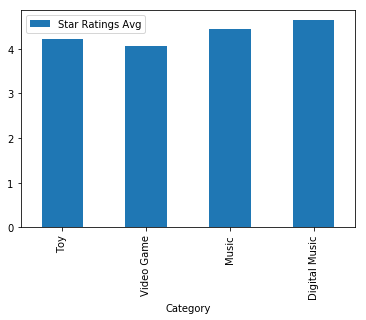

In [105]:
means.plot(kind= 'bar', x='Category')

In [107]:
toy.select('star_rating').summary().show()

+-------+-----------------+
|summary|      star_rating|
+-------+-----------------+
|  count|          4864243|
|   mean|4.211734693353107|
| stddev| 1.26335131645639|
|    min|                1|
|    25%|                4|
|    50%|                5|
|    75%|                5|
|    max|                5|
+-------+-----------------+



In [108]:
vidgame.select('star_rating').summary().show()

+-------+------------------+
|summary|       star_rating|
+-------+------------------+
|  count|           1785997|
|   mean| 4.059892597803915|
| stddev|1.3558117532896719|
|    min|                 1|
|    25%|                 4|
|    50%|                 5|
|    75%|                 5|
|    max|                 5|
+-------+------------------+



In [109]:
music.select('star_rating').summary().show()

+-------+-----------------+
|summary|      star_rating|
+-------+-----------------+
|  count|          4751540|
|   mean| 4.43662139011773|
| stddev|1.035927168222571|
|    min|                1|
|    25%|                4|
|    50%|                5|
|    75%|                5|
|    max|                5|
+-------+-----------------+



In [110]:
digimusic.select('star_rating').summary().show()

+-------+------------------+
|summary|       star_rating|
+-------+------------------+
|  count|           1688881|
|   mean| 4.642890766134499|
| stddev|0.8604533998421674|
|    min|                 1|
|    25%|                 5|
|    50%|                 5|
|    75%|                 5|
|    max|                 5|
+-------+------------------+



In [ ]:
trytoy = toy.select('review_date', 'star_rating') # streaming DataFrame of schema { timestamp: Timestamp, word: String }
trytoy = trytoy.toPandas()
trytoy.head(5)
# # Group the data by window and word and compute the count of each group
# windowedTry = trytoy.groupBy(
#     Window(trytoy.timestamp, "60 minutes", "30 minutes"),
#     trytoy.star_rating
# ).count()

In [136]:
import datetime
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import sum,avg,max,min,mean,count

In [154]:
yeartoy = toy.groupBy(year("review_date").alias("year")).agg(mean("star_rating").alias("mean")).orderBy(col("year"))

In [183]:
#convert Pyspark dataframe to Pandas dataframe for plotting
yeartoy2 = yeartoy.toPandas()

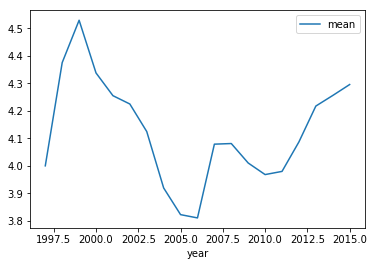

In [157]:
yeartoy2.plot.line(x='year',y='mean')

In [184]:
yearvidgame = vidgame.groupBy(year("review_date").alias("year")).agg(mean("star_rating").alias("mean")).orderBy(col("year"))
yearvidgame2 = yearvidgame.toPandas()

### Yearly Star Rating Avg Comparison Between Toy & Video Game

(1995, 2017)

(3.0, 5)

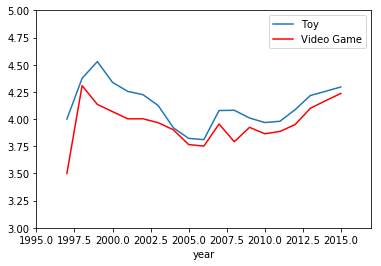

In [193]:
fig, ax = plt.subplots()

yeartoy2.plot.line(x='year', y='mean', ax=ax, label='Toy') # <--- pass ax=ax here
yearvidgame2.plot.line(x='year', y='mean',  color='r', ax=ax, label = 'Video Game') # <--- pass ax=ax here

plt.xlim(1995,2017)
plt.ylim(3.0,5)

plt.legend()
plt.show()

### Yearly Star Rating Avg Comparison Between Music & Digital Music

In [197]:
yearmusic = music.groupBy(year("review_date").alias("year")).agg(mean("star_rating").alias("mean")).orderBy(col("year"))
yearmusic2 = yearmusic.toPandas()

In [198]:
yeardigimusic = digimusic.groupBy(year("review_date").alias("year")).agg(mean("star_rating").alias("mean")).orderBy(col("year"))
yeardigimusic2 = yeardigimusic.toPandas()

(1992, 2017)

(3.5, 5)

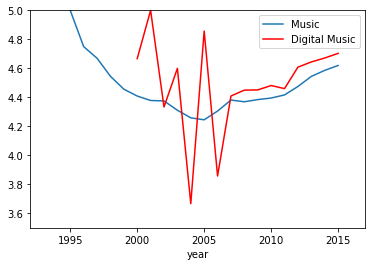

In [202]:
fig, ax = plt.subplots()

yearmusic2.plot.line(x='year', y='mean', ax=ax, label='Music') # <--- pass ax=ax here
yeardigimusic2.plot.line(x='year', y='mean',  color='r', ax=ax, label = 'Digital Music') # <--- pass ax=ax here

plt.xlim(1992,2017)
plt.ylim(3.5,5)

plt.legend()
plt.show()

### Star Rating Avg Comparison Between Music Vs Digital Music By Month (Regardless of Year)

In [203]:
momusic = music.groupBy(month("review_date").alias("month")).agg(mean("star_rating").alias("mean")).orderBy(col("month"))
momusic2 = momusic.toPandas()

In [204]:
modigimusic = digimusic.groupBy(month("review_date").alias("month")).agg(mean("star_rating").alias("mean")).orderBy(col("month"))
modigimusic2 = modigimusic.toPandas()

(1, 12)

(3.5, 5)

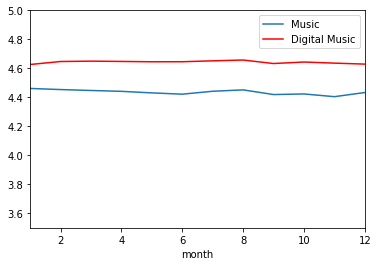

In [206]:
fig, ax = plt.subplots()

momusic2.plot.line(x='month', y='mean', ax=ax, label='Music') # <--- pass ax=ax here
modigimusic2.plot.line(x='month', y='mean',  color='r', ax=ax, label = 'Digital Music') # <--- pass ax=ax here

plt.xlim(1,12)
plt.ylim(3.5,5)

plt.legend()
plt.show()

### Star Rating Avg Comparison Between Toy & Video Game By Month (Regardless of Year)

(1, 12)

(3.5, 5)

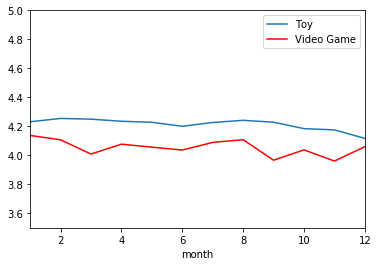

In [208]:
motoy = toy.groupBy(month("review_date").alias("month")).agg(mean("star_rating").alias("mean")).orderBy(col("month"))
motoy2 = motoy.toPandas()
movidgame = vidgame.groupBy(month("review_date").alias("month")).agg(mean("star_rating").alias("mean")).orderBy(col("month"))
movidgame2 = movidgame.toPandas()

fig, ax = plt.subplots()

motoy2.plot.line(x='month', y='mean', ax=ax, label='Toy') # <--- pass ax=ax here
movidgame2.plot.line(x='month', y='mean',  color='r', ax=ax, label = 'Video Game') # <--- pass ax=ax here

plt.xlim(1,12)
plt.ylim(3.5,5)

plt.legend()
plt.show()

In [214]:
#Products per Product Parent 
prparenttoy = toy.groupBy('product_parent').agg(count('product_id'))
prparentvidgame = vidgame.groupBy('product_parent').agg(count('product_id'))
prparentmusic = music.groupBy('product_parent').agg(count('product_id'))
prparentdigimusic = digimusic.groupBy('product_parent').agg(count('product_id'))

### Top Product Parent Based On Mean Star Rating

#### 263404 products have in average 5 ratings

In [226]:
prprtoy = toy.groupBy('product_parent').agg(mean('star_rating')).sort(col("avg(star_rating)").desc())

In [230]:
prprtoy.groupBy('avg(star_rating)').agg(count('product_parent')).show()

+------------------+---------------------+
|  avg(star_rating)|count(product_parent)|
+------------------+---------------------+
|               5.0|               263404|
|4.9818181818181815|                    1|
|              4.98|                    1|
|4.9787234042553195|                    1|
| 4.978260869565218|                    3|
| 4.977777777777778|                    2|
| 4.976744186046512|                    1|
| 4.976190476190476|                    1|
|             4.975|                    2|
|4.9743589743589745|                    3|
| 4.973684210526316|                    4|
| 4.972972972972973|                    8|
|4.9714285714285715|                    2|
| 4.970588235294118|                    1|
|  4.96969696969697|                    6|
|           4.96875|                    7|
| 4.967741935483871|                    5|
| 4.966666666666667|                    4|
| 4.966101694915254|                    1|
|4.9655172413793105|                   10|
+----------

#### 13386 products have in average 5 ratings

In [233]:
prprvidgame = vidgame.groupBy('product_parent').agg(mean('star_rating')).sort(col("avg(star_rating)").desc())
prprvidgame.groupBy('avg(star_rating)').agg(count('product_parent')).show()

+------------------+---------------------+
|  avg(star_rating)|count(product_parent)|
+------------------+---------------------+
|               5.0|                13386|
| 4.972222222222222|                    1|
|4.9714285714285715|                    1|
| 4.966101694915254|                    1|
| 4.961538461538462|                    1|
|              4.96|                    2|
| 4.958333333333333|                    1|
| 4.954545454545454|                    1|
|4.9523809523809526|                    2|
|              4.95|                    3|
| 4.949275362318841|                    1|
| 4.947368421052632|                    2|
| 4.944444444444445|                    5|
| 4.942857142857143|                    1|
|4.9411764705882355|                    7|
|            4.9375|                    9|
| 4.935483870967742|                    1|
| 4.934782608695652|                    1|
| 4.933333333333334|                    6|
| 4.928571428571429|                   13|
+----------

### Sum of Helpful Votes Per Product Parent

#### Interesting pattern of seeing product parent with the most number of helpful votes paired with lower average star_rating

In [239]:
toy.groupBy('product_parent').agg(sum('helpful_votes'), mean('star_rating')).sort(col("sum(helpful_votes)").desc()).show()

+--------------+------------------+------------------+
|product_parent|sum(helpful_votes)|  avg(star_rating)|
+--------------+------------------+------------------+
|     809260231|             43208| 2.986547085201794|
|     829220659|             29075|4.8597076384599545|
|     873299726|             28493| 4.529626623376624|
|     147901978|             18905| 3.409090909090909|
|     579462056|             16957|3.6844919786096257|
|     244796398|             16425|3.9158512720156557|
|     320546735|             14955| 4.658780231335436|
|     853385546|             10279| 4.227777777777778|
|     286256560|              9532| 4.246913580246914|
|     824071926|              7946| 4.219971056439942|
|     826592483|              7446|3.8699715562779358|
|     860841835|              6597|  4.34703196347032|
|     539899566|              6353| 4.647560491868306|
|     275514823|              6033|3.3293357933579335|
|      55838119|              5643| 4.376470588235295|
|     9063

In [238]:
vidgame.groupBy('product_parent').agg(sum('helpful_votes'), mean('star_rating')).sort(col("sum(helpful_votes)").desc()).show()

+--------------+------------------+------------------+
|product_parent|sum(helpful_votes)|  avg(star_rating)|
+--------------+------------------+------------------+
|     111226018|             53319| 2.433485622144585|
|     366059078|             50124|1.6473079249848759|
|     636511565|             48282| 4.163867979154603|
|     265303108|             39416| 1.452920443101712|
|      39181653|             23301|3.4581151832460733|
|     936979138|             17788|3.9295892707460185|
|     868275572|             17105|3.0697799248523885|
|     151985175|             12811| 2.488162344983089|
|     793022980|             11353| 3.176762661370407|
|     468471190|             11253|4.5337243401759535|
|     746038909|             11125| 1.697142857142857|
|     541259922|             10958| 3.808965228320067|
|     928566066|              8704|3.5884917175239757|
|     320220176|              8006| 4.248780487804878|
|     512137293|              7928| 4.351044504995459|
|      724

In [240]:
music.groupBy('product_parent').agg(sum('helpful_votes'), mean('star_rating')).sort(col("sum(helpful_votes)").desc()).show()

+--------------+------------------+------------------+
|product_parent|sum(helpful_votes)|  avg(star_rating)|
+--------------+------------------+------------------+
|     453915760|             20609| 4.402201524132091|
|     133243244|             18914| 4.492572786690434|
|     388483600|             12123| 2.800647088103534|
|     770378780|             11533|1.4059829059829059|
|       3458816|             10718| 4.798534798534798|
|     132646905|             10554| 3.287348586810229|
|     496059914|             10129| 4.841772151898734|
|     453610477|             10128| 3.183632734530938|
|     658034343|              9996|3.9835958005249346|
|     900371546|              9346| 4.258492129246065|
|     376609974|              8575| 4.580548414738646|
|     248144974|              7500| 4.312977099236641|
|     482689955|              7110| 4.013748191027497|
|     809803813|              7040| 3.384297520661157|
|     897909419|              6979| 4.040730337078652|
|     2951

In [241]:
digimusic.groupBy('product_parent').agg(sum('helpful_votes'), mean('star_rating')).sort(col("sum(helpful_votes)").desc()).show()

+--------------+------------------+------------------+
|product_parent|sum(helpful_votes)|  avg(star_rating)|
+--------------+------------------+------------------+
|     710124392|              3725| 3.844106463878327|
|      79351231|              3493|1.2912621359223302|
|     930328267|              1438|2.6596858638743455|
|     362621454|              1219|3.2835249042145596|
|     218937759|              1158| 4.746951219512195|
|     348335832|              1137|3.0913978494623655|
|     117182852|              1123|4.2656716417910445|
|     380805388|              1108| 2.129032258064516|
|     570268002|              1028|4.6117647058823525|
|     780153659|               969| 4.855704697986577|
|     223143825|               932| 4.004889975550122|
|     260957349|               916|4.0213523131672595|
|     999623290|               895| 3.437956204379562|
|     412555628|               874|1.9764705882352942|
|     419353887|               830|4.9010989010989015|
|     4112